<a href="https://www.kaggle.com/code/nkitgupta/bank-churn-prediction-auc-0-98?scriptVersionId=98883114" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Table of Contents</h1>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#1" role="tab" aria-controls="settings">1. Introduction<span class="badge badge-primary badge-pill">1</span></a>
<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">2. Exploratory Data Analysis <span class="badge badge-primary badge-pill">2</span></a>
<a class="list-group-item list-group-item-action"  data-toggle="list" href="#3" role="tab" aria-controls="settings">3. Missing Values<span class="badge badge-primary badge-pill">3</span></a>
   <a class="list-group-item list-group-item-action"  data-toggle="list" href="#4" role="tab" aria-controls="settings">4. Approaching Categorical Features<span class="badge badge-primary badge-pill">4</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#5" role="tab" aria-controls="settings">5. Evaluation Metrics<span class="badge badge-primary badge-pill">5</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#6" role="tab" aria-controls="settings">6. Model<span class="badge badge-primary badge-pill">6</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#7" role="tab" aria-controls="settings">7. Hyperparameter Tuning<span class="badge badge-primary badge-pill">7</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#8" role="tab" aria-controls="settings">8. Voting Classifier<span class="badge badge-primary badge-pill">8</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#9" role="tab" aria-controls="settings">9. References<span class="badge badge-primary badge-pill">9</span></a>

In this notebook i will try to predict who want to leave credit card services. So that he or she can proactively go to the customer to provide them better services and turn customer's decisions in the opposite direction  

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Introduction</h1><a id = "1" ></a>


The process involves applying for a credit card, getting approved, meeting a minimum spend within a set amount of time, earning a large welcome bonus, and canceling the card before the next annual fee is due. Once this is complete, the process is simply repeated again and again, hence the term churning.


![image.png](https://smartcdn.prod.postmedia.digital/financialpost/wp-content/uploads/2016/04/0428cards.jpg)


## Import important libraries and packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, log_loss, confusion_matrix
from xgboost import XGBClassifier
from functools import partial
from skopt import space
from skopt import gp_minimize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


import missingno

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


In [2]:
df = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

About Features in data

 *   CLIENTNUM : Client number. Unique identifier for the customer holding the account
 *   Attrition_Flag : Internal event (customer activity) variable - if the account is closed then 1 else 0             
 *   Customer_Age : Demographic variable - Customer's Age in Years              
 *   Gender : Demographic variable - M=Male, F=Female                   
 *   Dependent_count : Demographic variable - Number of dependents           
 *   Education_Level : Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)            
 *   Marital_Status : Demographic variable - Married, Single, Divorced, Unknown           
 *   Income_Category : Demographic variable - Annual Income Category of the account holder (< 40K, 40K - 60K, 60K - 80K, 80K-120K, >)           
 *   Card_Category : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)             
 *   Months_on_book : Period of relationship with bank           
 *  Total_Relationship_Count : Total no. of products held by the customer 
 *  Months_Inactive_12_mon : No. of months inactive in the last 12 months      
 *  Contacts_Count_12_mon : No. of Contacts in the last 12 months    
 *  Credit_Limit : Credit Limit on the Credit Card              
 *  Total_Revolving_Bal : Total Revolving Balance on the Credit Card       
 *  Avg_Open_To_Buy : Open to Buy Credit Line (Average of last 12 months)           
 *  Total_Amt_Chng_Q4_Q1 : Change in Transaction Amount (Q4 over Q1)     
 *  Total_Trans_Amt : Total Transaction Amount (Last 12 months)            
 *  Total_Trans_Ct : Total Transaction Count (Last 12 months)           
 *  Total_Ct_Chng_Q4_Q1 : Change in Transaction Count (Q4 over Q1)       
 *  Avg_Utilization_Ratio : Average Card Utilization Ratio    

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Exploratory Data Analysis</h1><a id = "2" ></a>

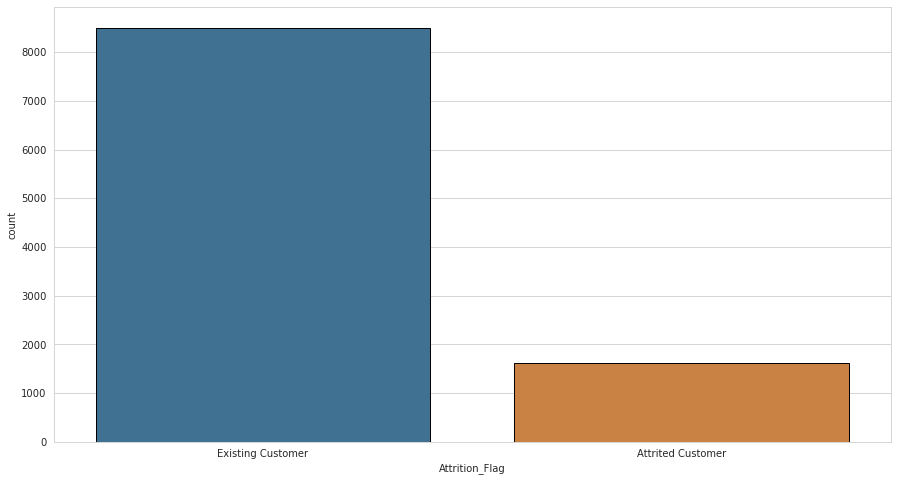

In [4]:
plt.figure(figsize = (15,8))
sns.countplot(x = df['Attrition_Flag'], edgecolor = 'black', saturation = 0.55)
plt.show()

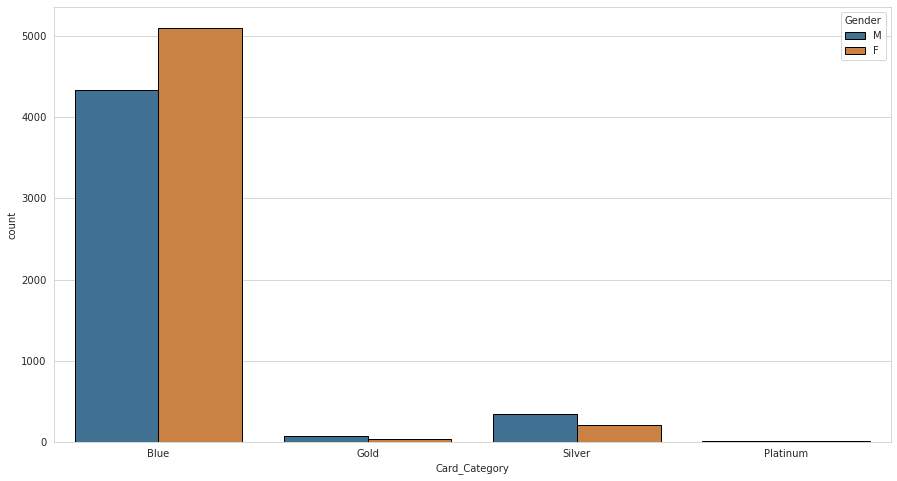

In [5]:
plt.figure(figsize = (15, 8))
sns.countplot(x = df['Card_Category'], hue = df['Gender'], edgecolor = 'black', saturation = 0.55)
plt.show()

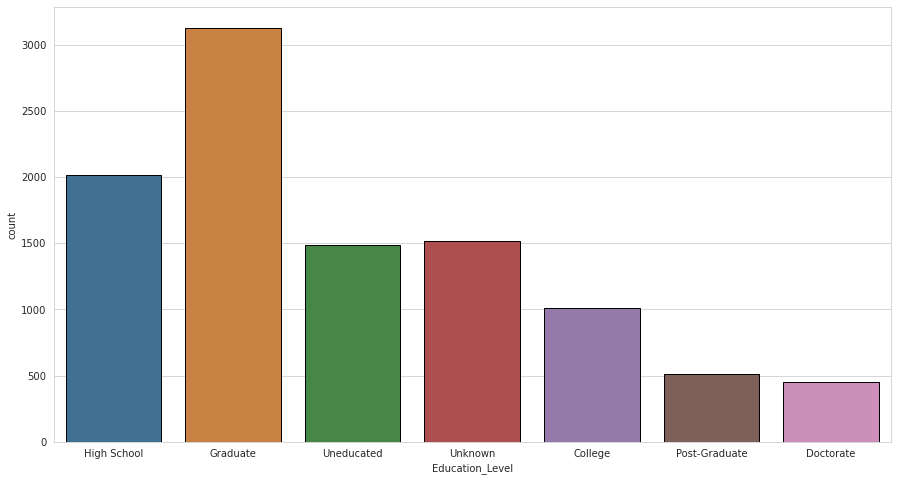

In [6]:
plt.figure(figsize = (15,8))
sns.countplot(x= df['Education_Level'], edgecolor = 'black', saturation = 0.55)
plt.show()

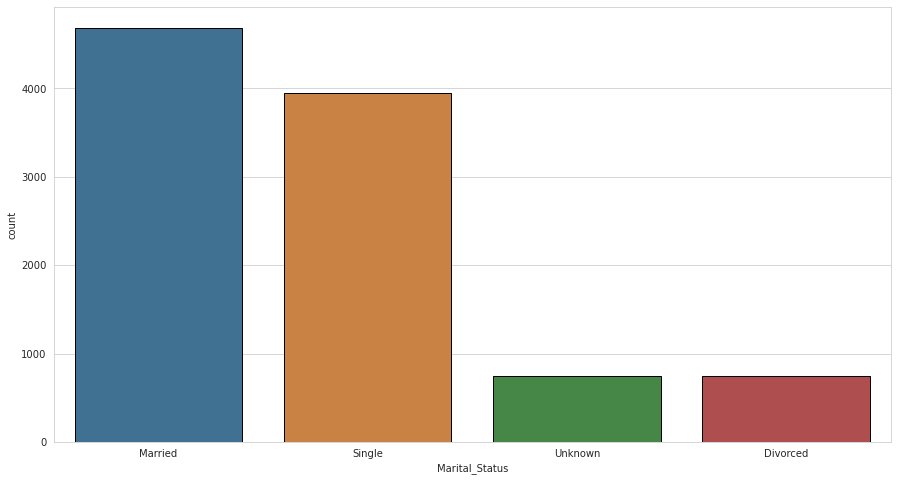

In [7]:
plt.figure(figsize = (15,8))
sns.countplot(x = df['Marital_Status'], edgecolor = 'black', saturation = 0.55)
plt.show()

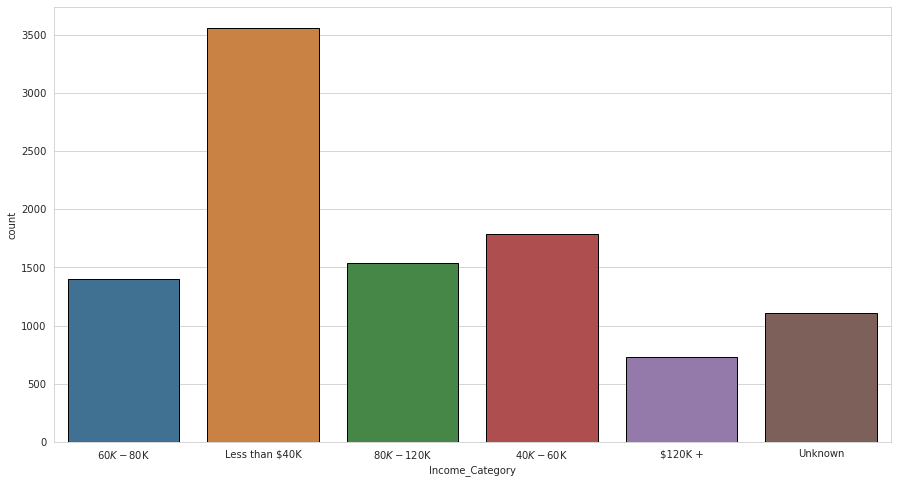

In [8]:
plt.figure(figsize = (15,8))
sns.countplot(x = df['Income_Category'], edgecolor = 'black', saturation = 0.55)
plt.show()

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Missing Values</h1><a id = "3" ></a>

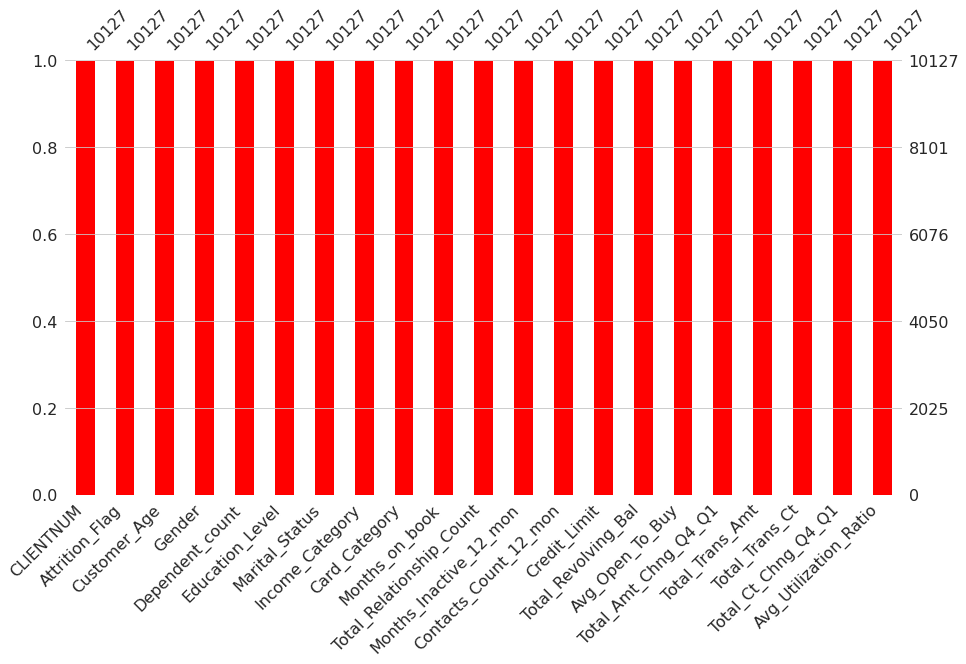

In [9]:
missingno.bar(df, color = 'red', figsize = (15,8))
plt.show()

From above plot we can say this data do not have any missing values but inplace of missing values many attributes have value "Unknown" which is same as missing values. Giving Nan values a seprate class (Unknown) in categorical variables is a great technique to deal with missing values in categorical variables 

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Approaching Categorical Features</h1><a id = "4" ></a>

Categorical variables/features are any feature type can be classified into two major
types:
*  Nominal
*  Ordinal

**Nominal variables** are variables that have two or more categories which do not
have any kind of order associated with them. For example, if gender is classified
into two groups, i.e. male and female, it can be considered as a nominal variable.

**Ordinal variables** on the other hand, have “levels” or categories with a particular
order associated with them. For example, an ordinal categorical variable can be a
feature with three different levels: low, medium and high. Order is important.

Ordinal variables in this data are :-

1. Income_Category
2. Card_Category
3. Education_Level

In this notebook i will seprately encode ordinal variables first

In [10]:
Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4,
    'Unknown'        : 5
}


Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
}


Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1
}

Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
}


df.loc[:, 'Income_Category'] = df['Income_Category'].map(Income_Category_map)
df.loc[:, 'Card_Category'] = df['Card_Category'].map(Card_Category_map)
df.loc[:, 'Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
df.loc[:, 'Education_Level'] = df['Education_Level'].map(Education_Level_map)


**Label Encoding** refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.
![](https://ekababisong.org/assets/seminar_IEEE/LabelEncoder.png)  

We can do label Encoding From LabelEncoder of scikit-Learn but to do so first we have to impute missing values in data 

In this Notebook i am going to use scikit-Learn LabelEncoder Due to following reasons

1. Label Encoder encode data on basis of count and this data do not have lots of ordinal features\ 
    
2. To use label encoder first we have to create NULL values as new category and in Our data this task is already done

In [11]:
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()

cat_cols = [x for x in df.columns if df[x].dtype == 'object']

for c in cat_cols:
    df.loc[:, c] = lbe.fit_transform(df.loc[:, c])

In [12]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,1,3,1,1,2,0,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,0,5,3,2,0,0,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,1,3,3,1,3,0,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,0,4,1,3,0,0,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,1,3,0,1,2,0,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  int64  
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  int64  
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  int64  
 6   Marital_Status            10127 non-null  int64  
 7   Income_Category           10127 non-null  int64  
 8   Card_Category             10127 non-null  int64  
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [14]:
df = df.sample(frac = 1).reset_index(drop = True) #To shuffle data

X = df.drop(['Attrition_Flag', 'CLIENTNUM'], axis = 1)
y = df.Attrition_Flag

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Evaluation Metrics</h1><a id = "5" ></a>

I think before selecting an optimal model for given data first we have to analayze target feature. Target Feature can be discrete in case of classification problem or continuous in case of Regression Problem

- **[Area under the ROC (Receiver Operating Characteristic) curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)** : AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

     **[Scikit-learn user guide for AUC under the ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)**


![](https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png?w=576)

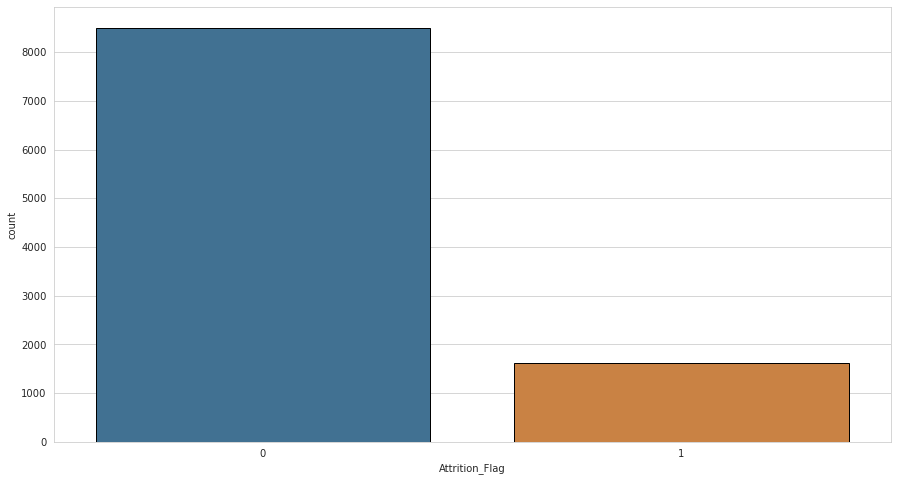

In [15]:
plt.figure(figsize = (15, 8))
sns.countplot(x = y, edgecolor = 'black', saturation = 0.55)
plt.show()

We can see that the target is **skewed** and thus the best metric for this binary classification problem would be Area Under the ROC Curve (AUC). We can use precision and recall too, but AUC combines these two metrics. Thus, we will be using AUC to evaluate the model that we build on this dataset.

In [16]:
def plot_roc_auc_curve(X, y, model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
    
    model.fit(x_train, y_train)
    y_predict = model.predict_proba(x_test)
    y_predict_proba = y_predict[:, 1]
    
    fpr , tpr, _ = roc_curve(y_test, y_predict_proba)
    
    plt.figure(figsize = (15,8))
    plt.plot(fpr, tpr, 'b+', linestyle = '-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr, tpr, alpha = 0.5 )
    auc_score = roc_auc_score(y_test, y_predict_proba)
    plt.title(f'ROC AUC Curve having \n AUC score : {auc_score}')
    

In [17]:
# funtion to plot learning curves

def plot_learning_curve(X, Y, model):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(100,len(x_train),100):
        
        model.fit(x_train.iloc[:m,:], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Model</h1><a id = "6" ></a>

In [18]:
#Cross Validation Score

from sklearn.model_selection import StratifiedKFold

def compute_CV(X, y, model, k):
    
    kf = StratifiedKFold(n_splits = k)
    auc_scores = []
    i = 0
    
    for idx in kf.split(X = X, y = y):
        
        train_idx, val_idx = idx[0], idx[1]
        
        i += 1 
        X_train = X.iloc[train_idx, :]
        y_train = y[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        y_predict = model.predict_proba(X_val)
        y_predict_prob = y_predict[:,1]
        
        auc_score = roc_auc_score(y_val, y_predict_prob)
        print(f'AUC Score of {i} Fold is : {auc_score}')
        auc_scores.append(auc_score)
    print('-----------------------------------------------')
    print(f'Average AUC Score of {k} Folds is : {np.mean(auc_scores)}')
    

**[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression)** is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).


**[Logistic regression Deep Intuition](https://machinelearningmastery.com/logistic-regression-for-machine-learning/)**

![](https://i.stack.imgur.com/bQVzF.png)

**[Sklearn User guide for Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)**

In [19]:
#Logistic Regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

std = StandardScaler()

data1 = std.fit_transform(X)

X_std = pd.DataFrame(data1, columns = X.columns)

clf1 = LogisticRegression()

compute_CV(X_std, y, clf1, 5)

AUC Score of 1 Fold is : 0.9216546373150487
AUC Score of 2 Fold is : 0.9126416456153014
AUC Score of 3 Fold is : 0.9360742081447964
AUC Score of 4 Fold is : 0.9220217194570135
AUC Score of 5 Fold is : 0.9224886877828053
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.922976179662993


**[Support Vector Machine (SVM)](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)** : The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

**[Support Vector Machine (SVM) Deep Intuition](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)**


![](https://static.javatpoint.com/tutorial/machine-learning/images/support-vector-machine-algorithm.png)

**[Sklearn User guide for Support Vector Machine (SVM)](https://miro.medium.com/max/921/1*06GSco3ItM3gwW2scY6Tmg.png)**

In [20]:
#SVM

from sklearn.svm import SVC

clf2 = SVC(probability = True, C = 100, kernel = 'rbf')

compute_CV(X_std, y, clf2, 5)

AUC Score of 1 Fold is : 0.9512098520389751
AUC Score of 2 Fold is : 0.9485014435221941
AUC Score of 3 Fold is : 0.9480180995475114
AUC Score of 4 Fold is : 0.9533538461538462
AUC Score of 5 Fold is : 0.955331221719457
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9512828925963968


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Hyperparameter Tunning</h1><a id = "7" ></a>

The parameters that the model has here are known as hyper-parameters, i.e. the parameters that control the training/fitting process of the model.

Let’s say there are three parameters a, b, c in the model, and
all these parameters can be integers between 1 and 10. A “correct” combination of
these parameters will provide you with the best result. So, it’s kind of like a suitcase
with a 3-dial combination lock. However, in 3 dial combination lock has only one
correct answer. The model has many right answers. So, how would you find the
best parameters? A method would be to evaluate all the combinations and see which
one improves the metric. We go through all the parameters from 1 to 10. So, we have a
total of 1000 (10 x 10 x 10) fits for the model. Well, that might be expensive because
the model can take a long time to train. Let's visit some efficient methods

* [Random Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) : Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.\
   [Scikit-Learn User Guide for Random Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
   
   
* [Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) : Define a search space as a grid of hyperparameter values and evaluate every position in the grid.\
   [Scikit-Learn User Guide for Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
   
   
Visit below given link for deep intuition of Random search and Grid search

[Hyperparameter Optimization With Random Search and Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

In this notebook i am using **Bayesian optimization with gaussian process**

[Hyperparameter Tuning With Bayesian Optimization](https://machinelearningmastery.com/what-is-bayesian-optimization/)



Bayesian optimization algorithm need a function they can optimize. Most of the time, it’s about the minimization of this function, like we minimize loss.


In [21]:
def optimize(params, param_names, x, y, model):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    
    if model == 'rf':
        clf = RandomForestClassifier(**params)
    
    elif model == 'xgb':
        clf = XGBClassifier(tree_method = 'hist', **params)
       
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]


        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)
    
    

**[Random Forest Classifier](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)** : Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

**[Random Forest Classifier Deep Intuition](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)**

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

**[Sklearn User guide for Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)**

So, let’s say, you want to find the best parameters for best accuracy and obviously, the more the accuracy is better. Now we cannot minimize the accuracy, but we can minimize it when we multiply it by -1. This way, we are minimizing the negative of accuracy, but in fact, we are maximizing accuracy. Using Bayesian optimization with gaussian process can be accomplished by using [gp_minimize function from scikit-optimize (skopt) library](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html). Let’s take a look at how we can tune the parameters of our xgboost model using this
function.

In [22]:
#define a parameter space

param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Integer(5,25, name = 'max_depth')
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators', 'max_depth']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = y, model = 'rf')

In [23]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 10, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 585, 'max_depth': 5}
AUC score of test 0 f 0.9646409238542043
Current parameters of fold number 1 -> {'n_estimators': 585, 'max_depth': 5}
AUC score of test 1 f 0.9602327679538072
Current parameters of fold number 2 -> {'n_estimators': 585, 'max_depth': 5}
AUC score of test 2 f 0.9718171945701357
Current parameters of fold number 3 -> {'n_estimators': 585, 'max_depth': 5}
AUC score of test 3 f 0.9707601809954752
Current parameters of fold number 4 -> {'n_estimators': 585, 'max_depth': 5}
AUC score of test 4 f 0.9698226244343893
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.4080
Function value obtained: -0.9675
Current minimum: -0.9675
Iteration No: 2 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 719, 'max_depth': 6}
AUC score of test 0 f 0.9739841212558643
Current parameters of fold number 

In [24]:
best_params_rf = dict(zip(param_names, result.x))
print(f'Best Parameters for RandomForestClassifier are  : {best_params_rf}')
print(f'Best AUC score : {-result.fun}')

Best Parameters for RandomForestClassifier are  : {'n_estimators': 1998, 'max_depth': 21}
Best AUC score : 0.9896185931210615


In [25]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(**best_params_rf)

compute_CV(X, y, clf3, 5)

AUC Score of 1 Fold is : 0.9877201371346085
AUC Score of 2 Fold is : 0.9888099963911945
AUC Score of 3 Fold is : 0.9908135746606335
AUC Score of 4 Fold is : 0.9887031674208145
AUC Score of 5 Fold is : 0.9920452488687783
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9896184248952059


**[Extreme Gradient Boosting (XGBoost)](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/)** : xgboost is short for eXtreme Gradient Boosting package. It is an efficient and scalable implementation of gradient boosting framework by (Friedman, 2001) (Friedman et al., 2000). The package includes efficient linear model solver and tree learning algorithm. It supports various objective functions, including regression, classification and ranking. The package is made to be extendible, so that users are also allowed to define their own objectives easily.

![](https://miro.medium.com/max/777/1*l4PN8hyAO4fMLxUbIxcETA.png)

In [26]:
#define a parameter space

param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Real(0.01,100, name = 'min_child_weight'),
                space.Real(0.01,1000, name = 'gamma'),
                space.Real(0.1, 1, prior = 'uniform', name = 'colsample_bytree'),
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators' ,'min_child_weight', 'gamma', 'colsample_bytree']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = y, model = 'xgb')

In [27]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 10, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
[17:51:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 0 -> {'n_estimators': 597, 'min_child_weight': 20.892365048325733, 'gamma': 538.8986865158491, 'colsample_bytree': 0.2767821154083333}
AUC score of test 0 f 0.9400721761097077
[17:51:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 1 -> {'n_estimators': 597, 'min_child_weight': 20.892365048325733, 'gamma': 538.8986865158491, 'colsample_bytree': 0.2767821154083333}
AUC score of test 1 f 0.9371048357993503
[17:51:27] WAR

In [28]:
best_params_xgb = dict(zip(param_names, result.x))
print(f"Best Parameters for XGBClassifier are : {best_params_xgb}")
print(f"Best AUC score {result.fun}")

Best Parameters for XGBClassifier are : {'n_estimators': 2000, 'min_child_weight': 7.816645372390785, 'gamma': 0.01, 'colsample_bytree': 0.33515577655480894}
Best AUC score -0.9919828387419148


In [29]:
#XGboost
clf4 = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', **best_params_xgb)

compute_CV(X, y, clf4, 5)

AUC Score of 1 Fold is : 0.9900811981234212
AUC Score of 2 Fold is : 0.9923998556477807
AUC Score of 3 Fold is : 0.9921502262443439
AUC Score of 4 Fold is : 0.9926171945701356
AUC Score of 5 Fold is : 0.9932036199095022
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9920904188990367


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Voting Classifier</h1><a id = "8" ></a>

A collection of several models working together on a single set is called an ensemble. The method is called Ensemble Learning. It is much more useful use all different models rather than any one.

![](https://miro.medium.com/max/891/1*I7NsQXwyR36XK62s1iDNzQ.png)

Voting is one of the simplest way of combining the predictions from multiple machine learning algorithms. Voting classifier isn’t an actual classifier but a wrapper for set of different ones that are trained and valuated in parallel in order to exploit the different peculiarities of each algorithm.


**[Voting Classifier Deep Intuition](https://towardsdatascience.com/how-voting-classifiers-work-f1c8e41d30ff)**

In [30]:
#Voting Classifier

from sklearn.ensemble import VotingClassifier

clf5 = VotingClassifier(
               estimators = [('lr', clf1), ('svm', clf2), ('rf', clf3), ('xgb', clf4)],
               voting = 'soft')

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms (That's why I used 4 different classifiers). This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

There is a hyperparameter voting in VotingClassifier we can set it hard or soft 

In hard voting, the VotingClassifier counts the number of each Class instance and then assigns to a test instance a class that was voted by majority of the classifiers.

If all classifiers in VotingClassifier are able to estimate class probabilities (i.e., they have a predict_proba() method), then we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All we need to do is to set voting="soft" and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so we need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).

In [31]:
compute_CV(X_std, y, clf5, 6)

AUC Score of 1 Fold is : 0.9877866809719615
AUC Score of 2 Fold is : 0.9875392896483658
AUC Score of 3 Fold is : 0.9895913355746119
AUC Score of 4 Fold is : 0.9874168960461659
AUC Score of 5 Fold is : 0.98937043037554
AUC Score of 6 Fold is : 0.9890732170033565
-----------------------------------------------
Average AUC Score of 6 Folds is : 0.988462974936667


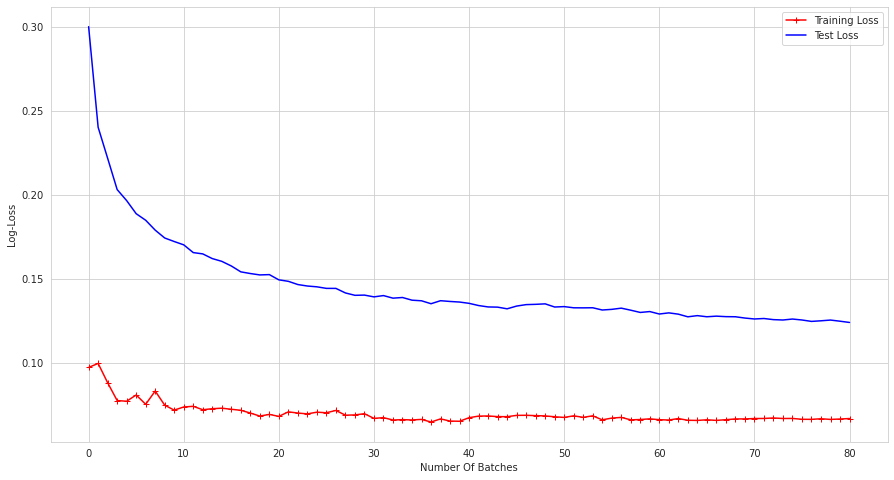

In [32]:
plot_learning_curve(X_std, y, clf5)

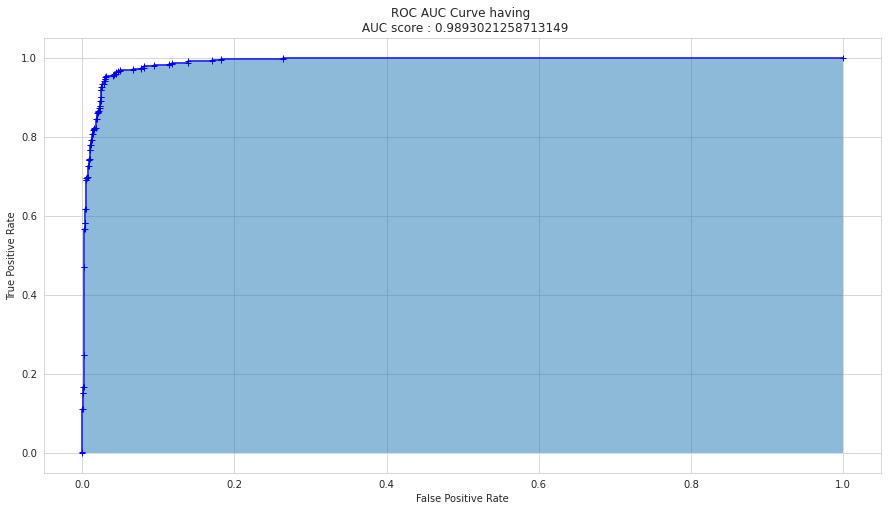

In [33]:
plot_roc_auc_curve(X_std, y, clf5)

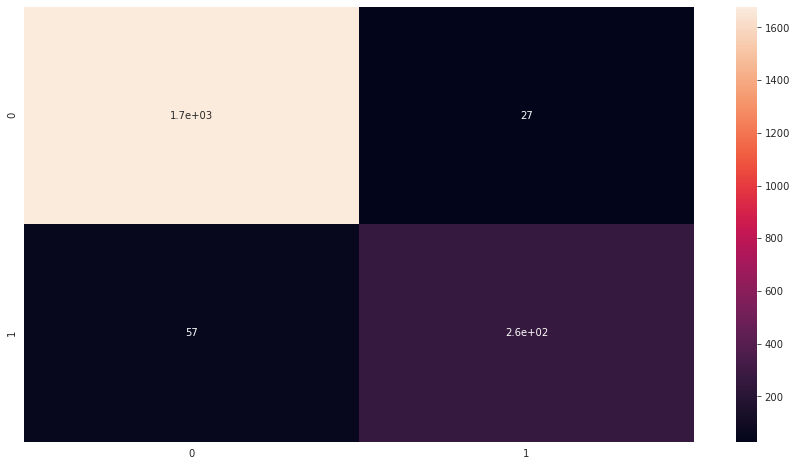

In [34]:
#plot confusion matrix

x_train, x_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 11)

clf5.fit(x_train, y_train)
y_predict = clf5.predict(x_test)

plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_predict), annot = True)
plt.show()

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Reference</h1><a id = "9" ></a>


1. [Learning Curves](https://www.kaggle.com/nkitgupta/who-will-leave-a-job)

2. [ROC AUC Curves](https://www.kaggle.com/nkitgupta/who-will-leave-a-job)

3. [Evaluation Metrics](https://www.kaggle.com/nkitgupta/who-will-leave-a-job)

4. [XGB Classifier](https://mran.microsoft.com/web/packages/xgboost/vignettes/xgboost.pdf)

5. [Hard Voting versus Soft Voting](https://stats.stackexchange.com/questions/320156/hard-voting-versus-soft-voting-in-ensemble-based-methods)

6. [Why Normalization is not required for tree based models](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/160613)

7. [Kaggle notebook for Categorical Encoding Methods](https://www.kaggle.com/arashnic/an-overview-of-categorical-encoding-methods)

8. [How to Implement Bayesian Optimization from Scratch in Python](https://machinelearningmastery.com/what-is-bayesian-optimization/)